# Physics Informed Neural Network for Cylinder Flow

## Overview

Flow past cylinder problem is a two-dimensional low velocity steady flow around a cylinder which is only related to the `Re` number. When `Re` is less than or equal to 1, the inertial force in the flow field is secondary to the viscous force, the streamlines in the upstream and downstream directions of the cylinder are symmetrical, and the drag coefficient is approximately inversely proportional to `Re` . The flow around this `Re` number range is called the Stokes zone; With the increase of `Re` , the streamlines in the upstream and downstream of the cylinder gradually lose symmetry. This special phenomenon reflects the peculiar nature of the interaction between the fluid and the surface of the body. Solving flow past a cylinder is a classical problem in hydromechanics.

Since it is difficult to obtain the generalized theoretical solution of the Navier-Stokes equation,the numerical method is used to solve the governing equation in the flow past cylinder scenario to predict the flow field, which is also a classical problem in computational fluid mechanics. Traditional solutions often require fine discretization of the fluid to capture the phenomena that need to be modeled. Therefore, traditional finite element method (FEM) and finite difference method (FDM) are often costly.

Physics-informed Neural Networks (PINNs) provides a new method for quickly solving complex fluid problems by using loss functions that approximate governing equations coupled with simple network configurations. In this case, the data-driven characteristic of neural network is used along with `PINNs` to solve the flow past cylinder problem.

## Problem Description

The Navier-Stokes equation, referred to as `N-S` equation, is a classical partial differential equation in the field of fluid mechanics. In the case of viscous incompressibility, the dimensionless `N-S` equation has the following form:

$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$

$$
\frac{\partial u} {\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = - \frac{\partial p}{\partial x} + \frac{1} {Re} (\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2})
$$

$$
\frac{\partial v} {\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = - \frac{\partial p}{\partial y} + \frac{1} {Re} (\frac{\partial^2v}{\partial x^2} + \frac{\partial^2v}{\partial y^2})
$$

where `Re` stands for Reynolds number.

In this case, the PINNs method is used to learn the mapping from the location and time to flow field quantities to solve the `N-S` equation.

$$
(x, y, t) \mapsto (u, v, p)
$$

In [1]:
import numpy as np

from mindspore.common import set_seed
from mindspore import context, Tensor, nn
from mindspore.train import DynamicLossScaleManager
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig
from mindspore.train.serialization import load_checkpoint, load_param_into_net
import mindspore.common.dtype as mstype

from mindflow.loss import Constraints
from mindflow.solver import Solver
from mindflow.common import L2, LossAndTimeMonitor
from mindflow.loss import MTLWeightedLossCell
from mindflow.pde import NavierStokes2D
from mindflow.utils import load_yaml_config

set_seed(123456)
np.random.seed(123456)

In [2]:
# set context for training: using graph mode for high performance training with GPU acceleration
context.set_context(mode=context.GRAPH_MODE, save_graphs=False, device_target="GPU", device_id=6)

In [3]:
# load configuration
config = load_yaml_config('cylinder_flow.yaml')

## Training Dataset Construction

In this case, the initial condition and boundary condition data of the existing flow around a cylinder with Reynolds number 100 are sampled. For the training dataset, the problem domain and time dimension of planar rectangle are constructed. Then the known initial conditions and boundary conditions are sampled. The validation set is constructed based on the existing points in the flow field.


In [4]:
from src import create_training_dataset

# create cylinder flow dataset
cylinder_dataset = create_training_dataset(config)
train_dataset = cylinder_dataset.create_dataset(batch_size=config["train_batch_size"],
                                                shuffle=True,
                                                prebatched_data=True,
                                                drop_remainder=True)

/data5/hsliu/mindflow/MindFlowtmp/applications/physics_driven/flow_past_cylinder_new_config/dataset


## Multi-task learning for adaptive losses

The PINNs method needs to optimize multiple losses at the same time, and brings challenges to the optimization process. Here, we adopt the uncertainty weighting algorithm proposed in ***Kendall, Alex, Yarin Gal, and Roberto Cipolla. "Multi-task learning using uncertainty to weigh losses for scene geometry and semantics." CVPR, 2018.*** to dynamically adjust the weights.

In [ ]:
mtl = MTLWeightedLossCell(num_losses=cylinder_dataset.num_dataset)

## Model Construction

This example uses a simple fully-connected network with a depth of 6 layers and the activation function is the `tanh` function.

In [5]:
from src import FlowNetwork

model = FlowNetwork(config["model"]["in_channels"],
                    config["model"]["out_channels"],
                    coord_min=config["geometry"]["coord_min"] + [config["geometry"]["time_min"]],
                    coord_max=config["geometry"]["coord_max"] + [config["geometry"]["time_max"]],
                    num_layers=config["model"]["layers"],
                    neurons=config["model"]["neurons"],
                    residual=config["model"]["residual"])

if config["load_ckpt"]:
    param_dict = load_checkpoint(config["load_ckpt_path"])
    load_param_into_net(model, param_dict)
    load_param_into_net(mtl, param_dict)

if context.get_context(attr_key='device_target') == "Ascend":
    model.to_float(mstype.float16)

## Constraints

The `Constraints` class relates the PDE problems with the training datasets. `NavierStokes2D` contains the governing equations, boundary conditions and initial conditions for solving the problem. The governing equation directly uses the incompressible `N-S` equation. The initial conditions and boundary conditions are obtained from the known data. Users can set different boundary conditions according to different data sets.

In [7]:

problem_list = [NavierStokes2D(model=model, re=config["Re"]) for i in range(cylinder_dataset.num_dataset)]
train_constraints = Constraints(cylinder_dataset, problem_list)

## Optimizer

In [8]:
from src import MultiStepLR

params = model.trainable_params() + mtl.trainable_params()
lr_scheduler = MultiStepLR(config["optimizer"]["initial_lr"],
                           config["optimizer"]["milestones"],
                           config["optimizer"]["gamma"],
                           len(cylinder_dataset),
                           config["train_epochs"])
lr = lr_scheduler.get_lr()
optimizer = nn.Adam(params, learning_rate=Tensor(lr))

## Model Training

Invoke the `Solver` interface for model training and `callback` interface for evaluation.

In [9]:
solver = Solver(model,
                optimizer=optimizer,
                train_constraints=train_constraints,
                metrics={'l2': L2(), 'distance': nn.MAE()},
                loss_fn='smooth_l1_loss',
                loss_scale_manager=DynamicLossScaleManager(init_loss_scale=2 ** 10, scale_window=2000),
                mtl_weighted_cell=mtl,
                )

In [10]:
from src import create_evaluation_dataset, PredictCallback, visualization

loss_time_callback = LossAndTimeMonitor(len(cylinder_dataset))
callbacks = [loss_time_callback]
if config.get("train_with_eval", False):
    inputs, label = create_evaluation_dataset(config["test_data_path"])
    predict_callback = PredictCallback(model, inputs, label, config=config, visual_fn=visualization)
    callbacks += [predict_callback]
if config["save_ckpt"]:
    config_ck = CheckpointConfig(save_checkpoint_steps=10,
                                 keep_checkpoint_max=2)
    ckpoint_cb = ModelCheckpoint(prefix='ckpt_flow_past_cylinder_Re100',
                                 directory=config["save_ckpt_path"], config=config_ck)
    callbacks += [ckpoint_cb]

get dataset path: /data5/hsliu/mindflow/MindFlowtmp/applications/physics_driven/flow_past_cylinder_new_config/dataset
check eval dataset length: (36, 100, 50, 3)


[WARNING] ME(39471:139667684352576,MainProcess):2022-11-08-11:46:02.344.628 [mindspore/train/model.py:1078] For LossAndTimeMonitor callback, {'epoch_end', 'epoch_begin'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.
[WARNING] ME(39471:139667684352576,MainProcess):2022-11-08-11:46:02.346.867 [mindspore/train/model.py:1078] For PredictCallback callback, {'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.
[WARNING] ME(39471:139667684352576,MainProcess):2022-11-08-11:46:06.106.712 [mindspore/ops/primitive.py:710] The "_check_type" is a constexpr function. The input arguments must be all constant value.
[WARNING] ME(39471:139667684352576,MainProcess):2022-11-08-11:46:06.108.169 [mindspore/ops/primitive.py:710] The "_check_type" is a constexpr function. The input arguments must be all constant value.
[W

epoch: 1 step: 8, loss is 2.1851492
epoch time: 13.851 s, per step time: 1731.400 ms
epoch: 2 step: 8, loss is 2.0964916
epoch time: 1.008 s, per step time: 125.968 ms
epoch: 3 step: 8, loss is 2.0464363
epoch time: 0.995 s, per step time: 124.364 ms
epoch: 4 step: 8, loss is 2.011204
epoch time: 0.990 s, per step time: 123.731 ms
epoch: 5 step: 8, loss is 1.980756
epoch time: 0.989 s, per step time: 123.563 ms
epoch: 6 step: 8, loss is 1.9525688
epoch time: 0.986 s, per step time: 123.235 ms
epoch: 7 step: 8, loss is 1.9255759
epoch time: 0.983 s, per step time: 122.871 ms
epoch: 8 step: 8, loss is 1.8993695
epoch time: 0.987 s, per step time: 123.340 ms
epoch: 9 step: 8, loss is 1.8734565
epoch time: 0.985 s, per step time: 123.102 ms
epoch: 10 step: 8, loss is 1.8480496
epoch time: 0.987 s, per step time: 123.313 ms
epoch: 11 step: 8, loss is 1.8224823
epoch time: 0.984 s, per step time: 123.040 ms
epoch: 12 step: 8, loss is 1.7973733
epoch time: 0.986 s, per step time: 123.196 ms
e

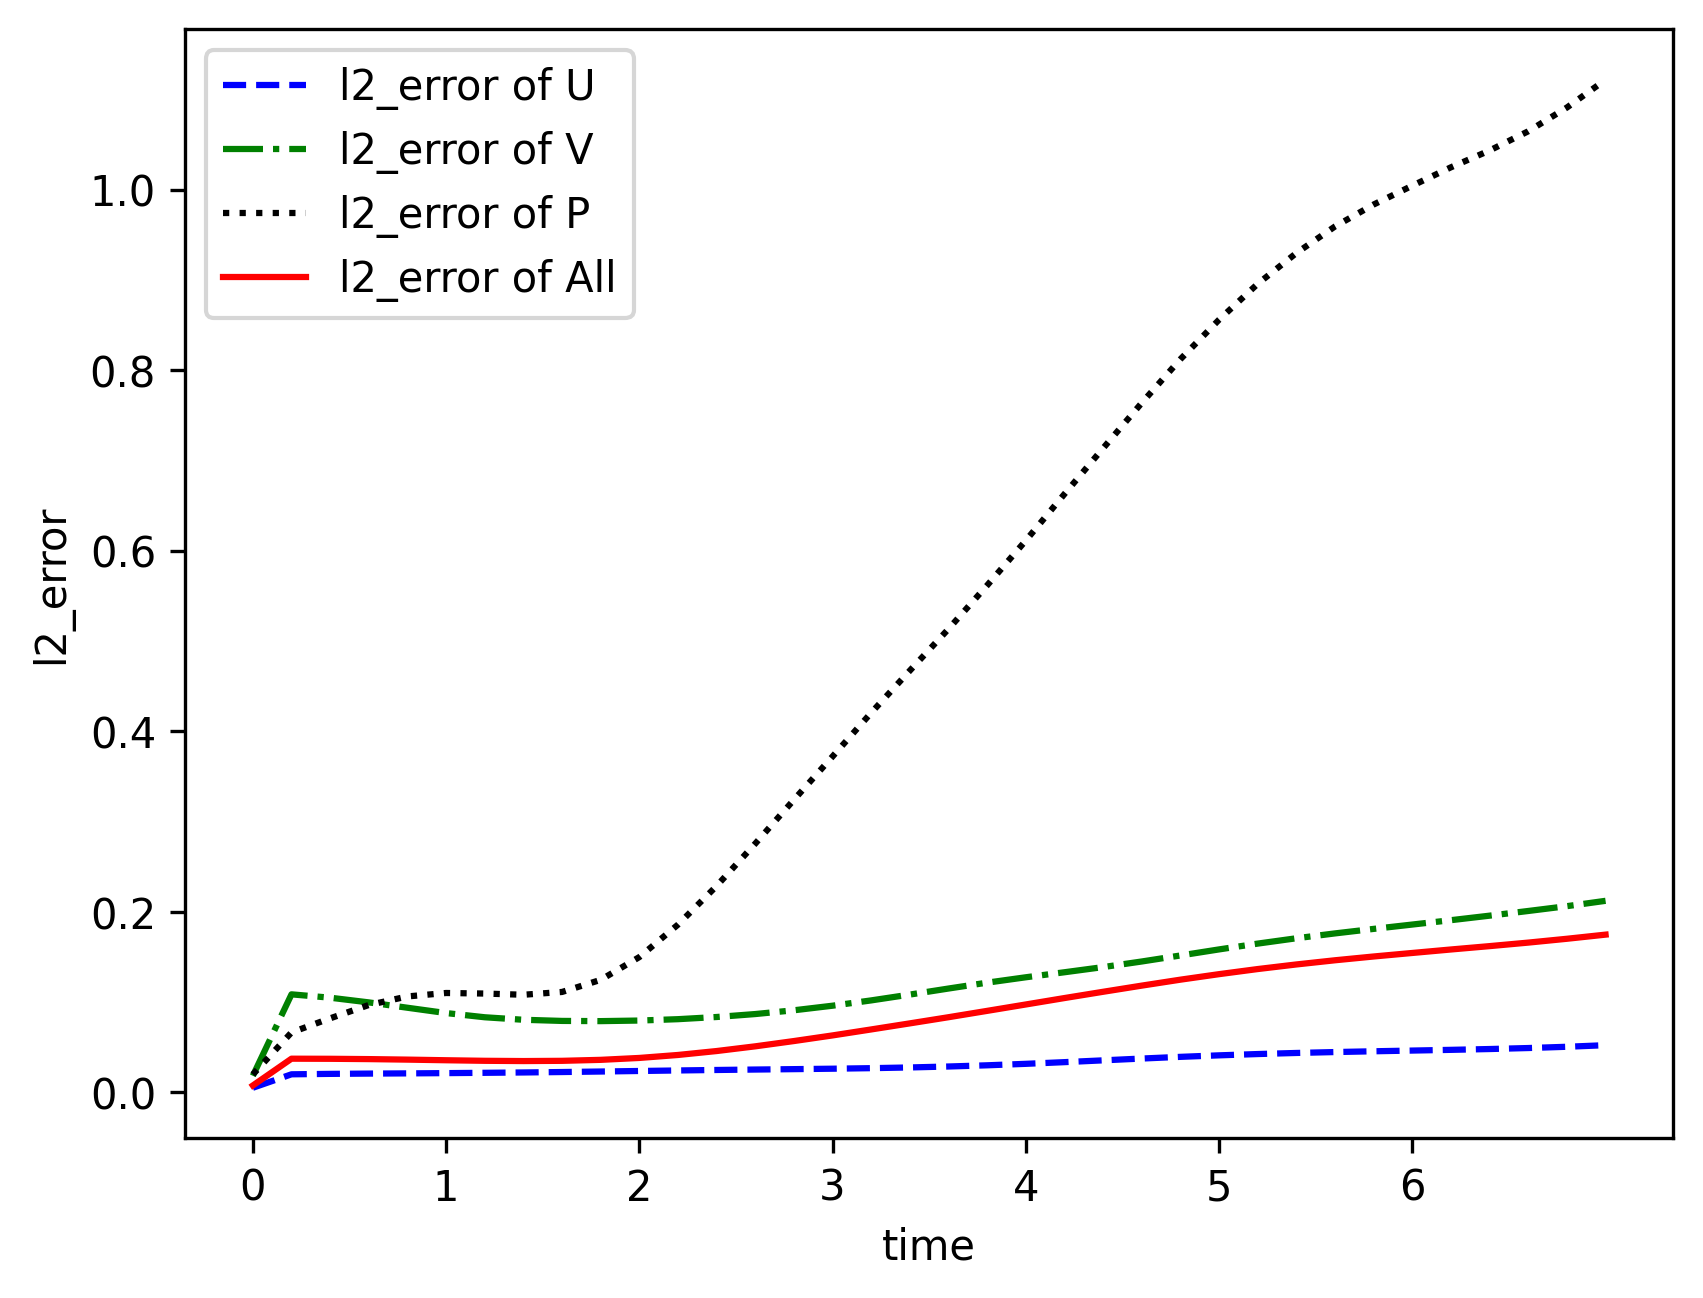

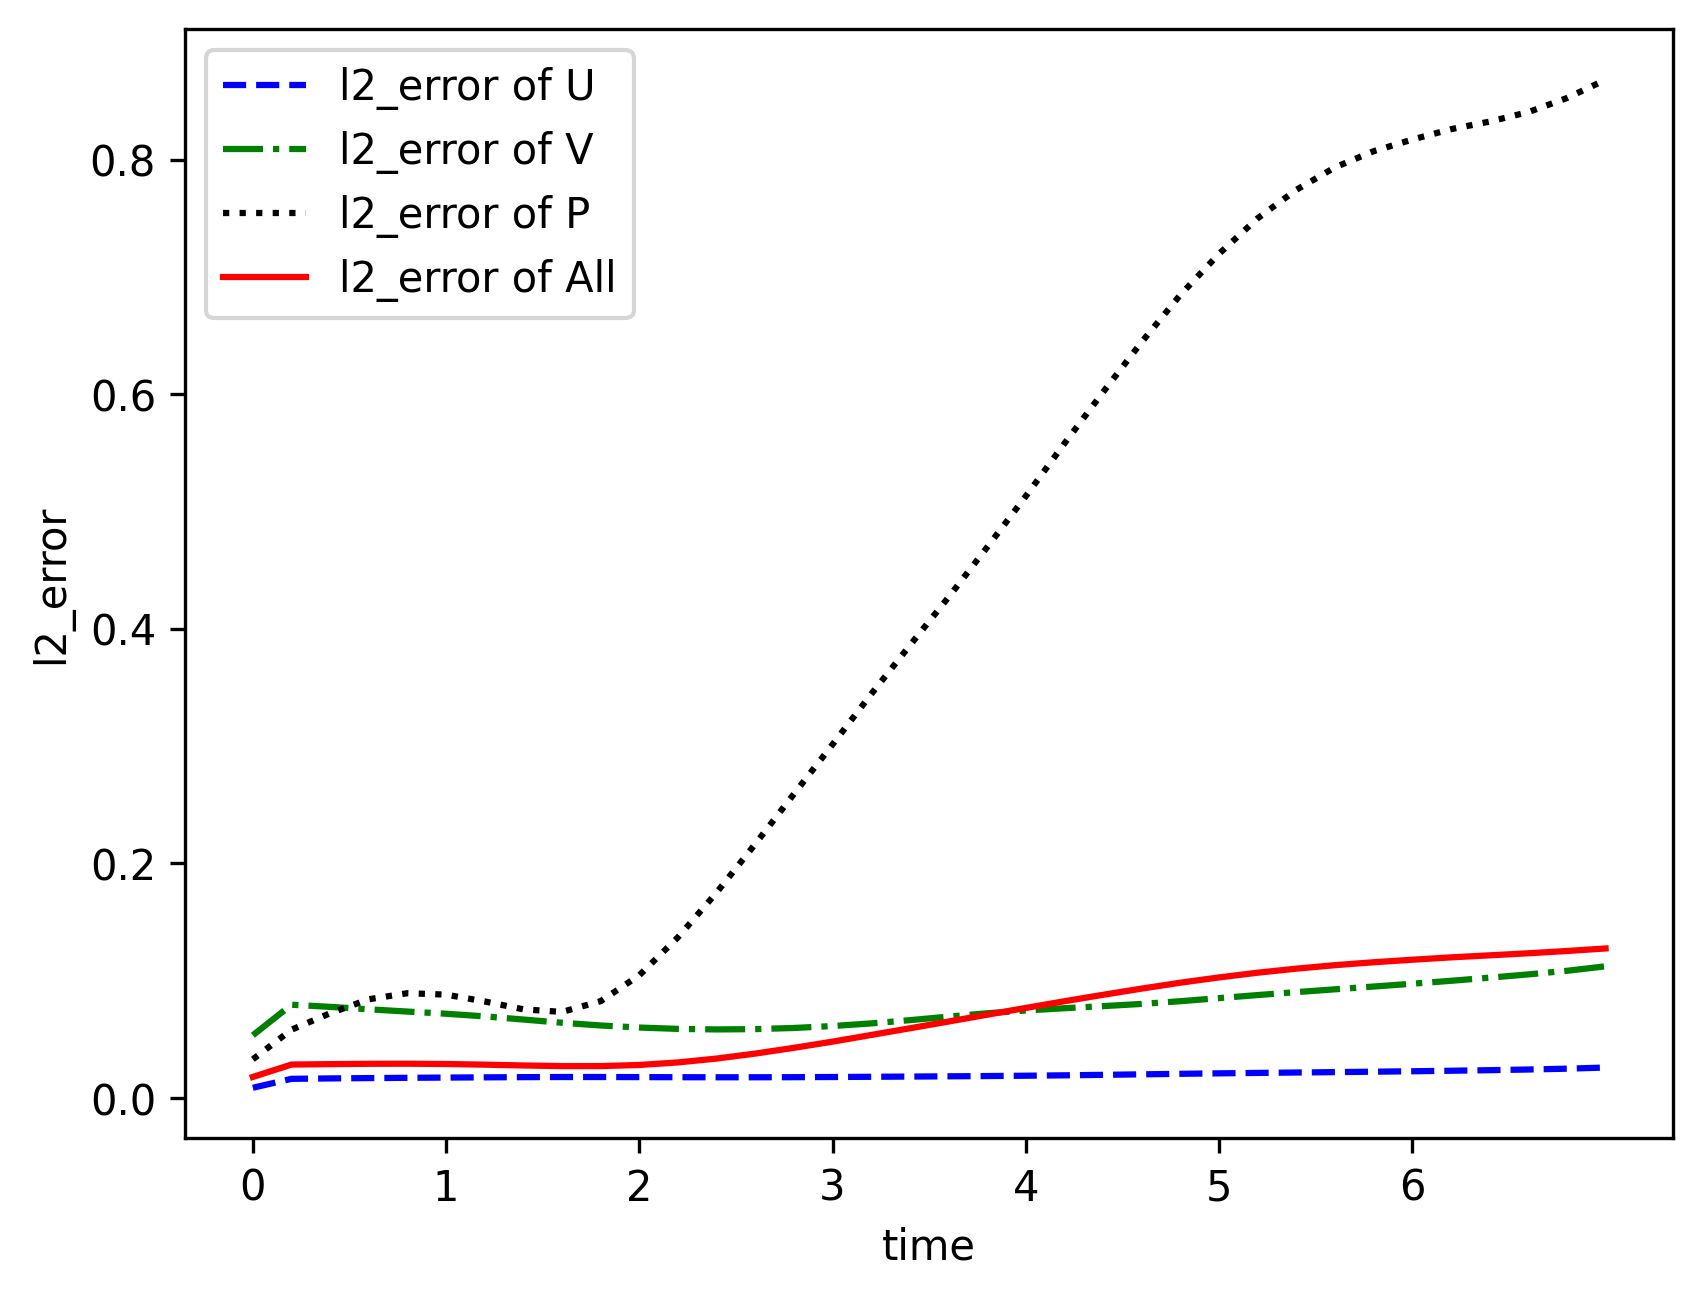

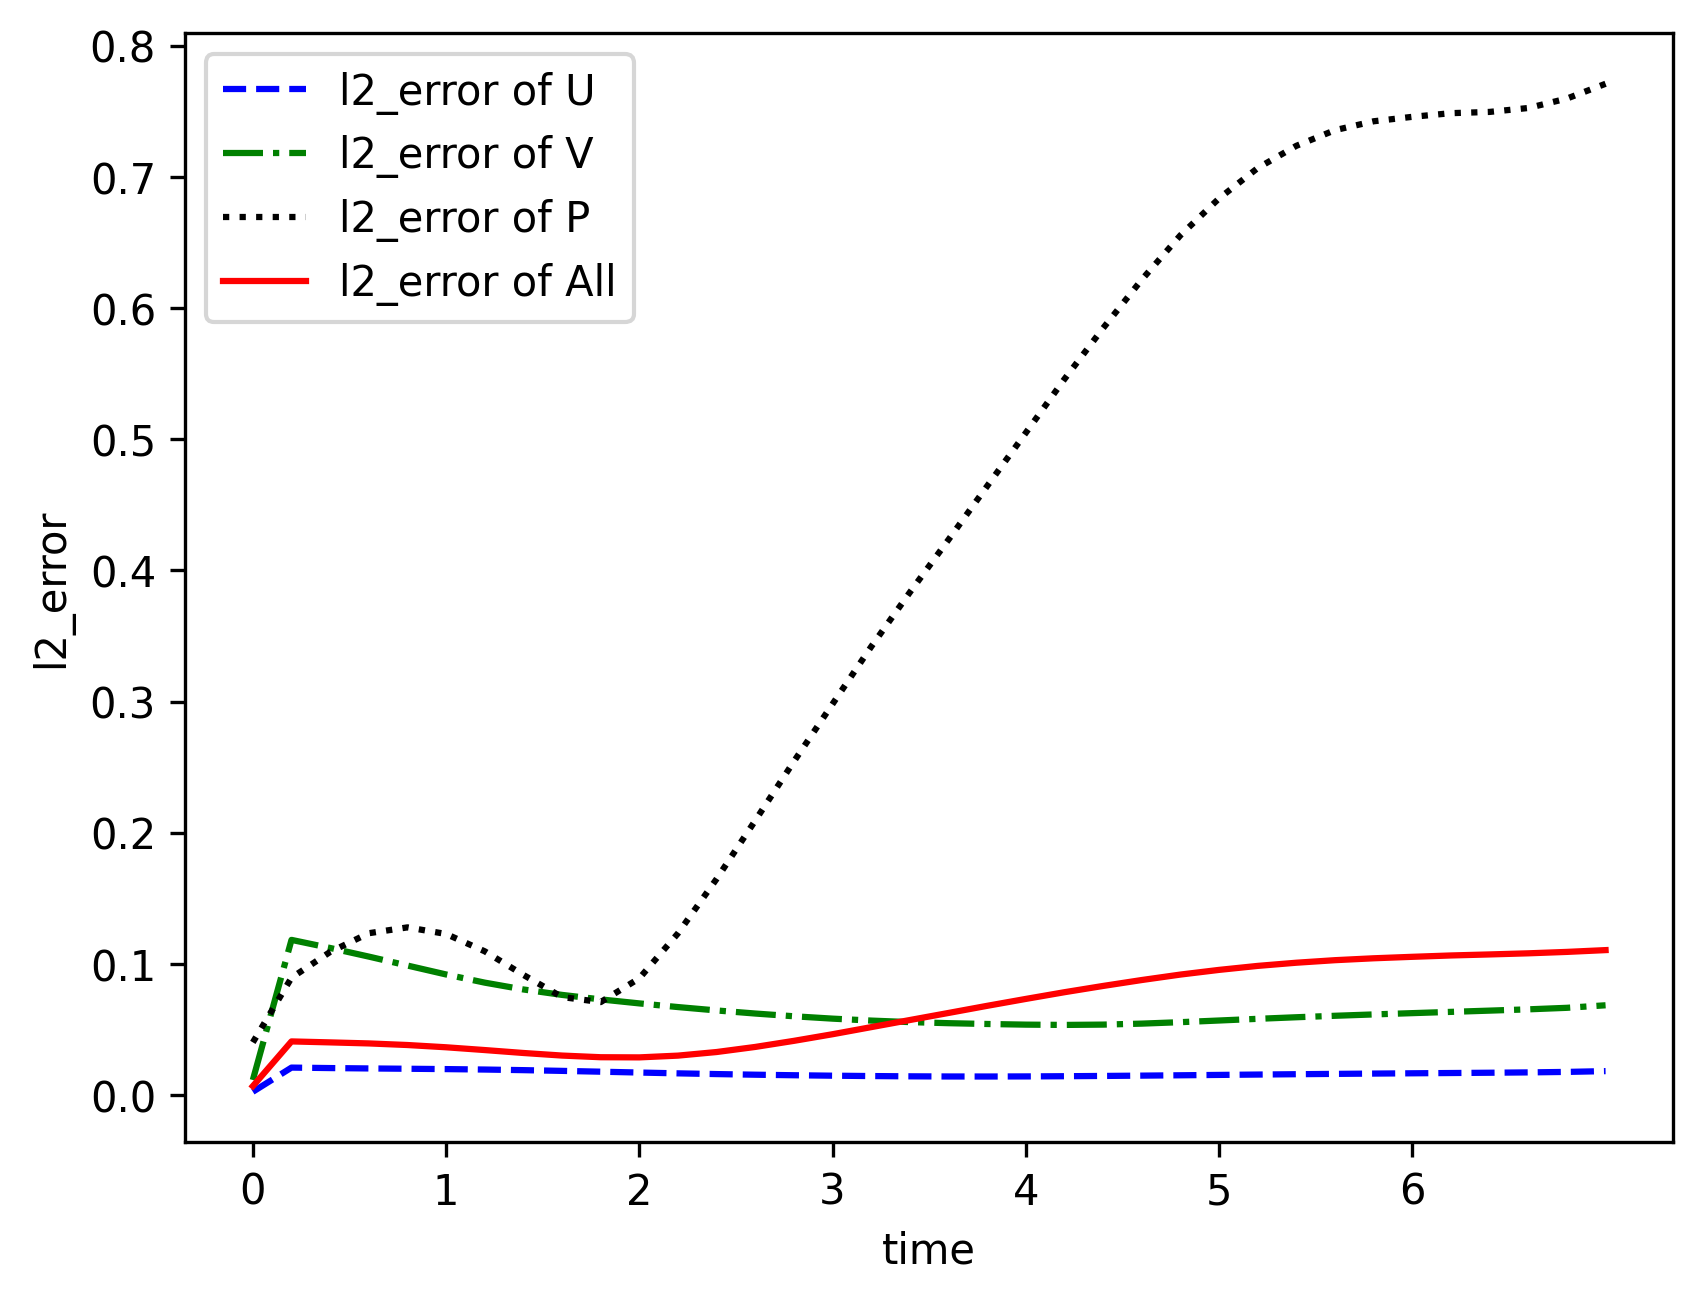

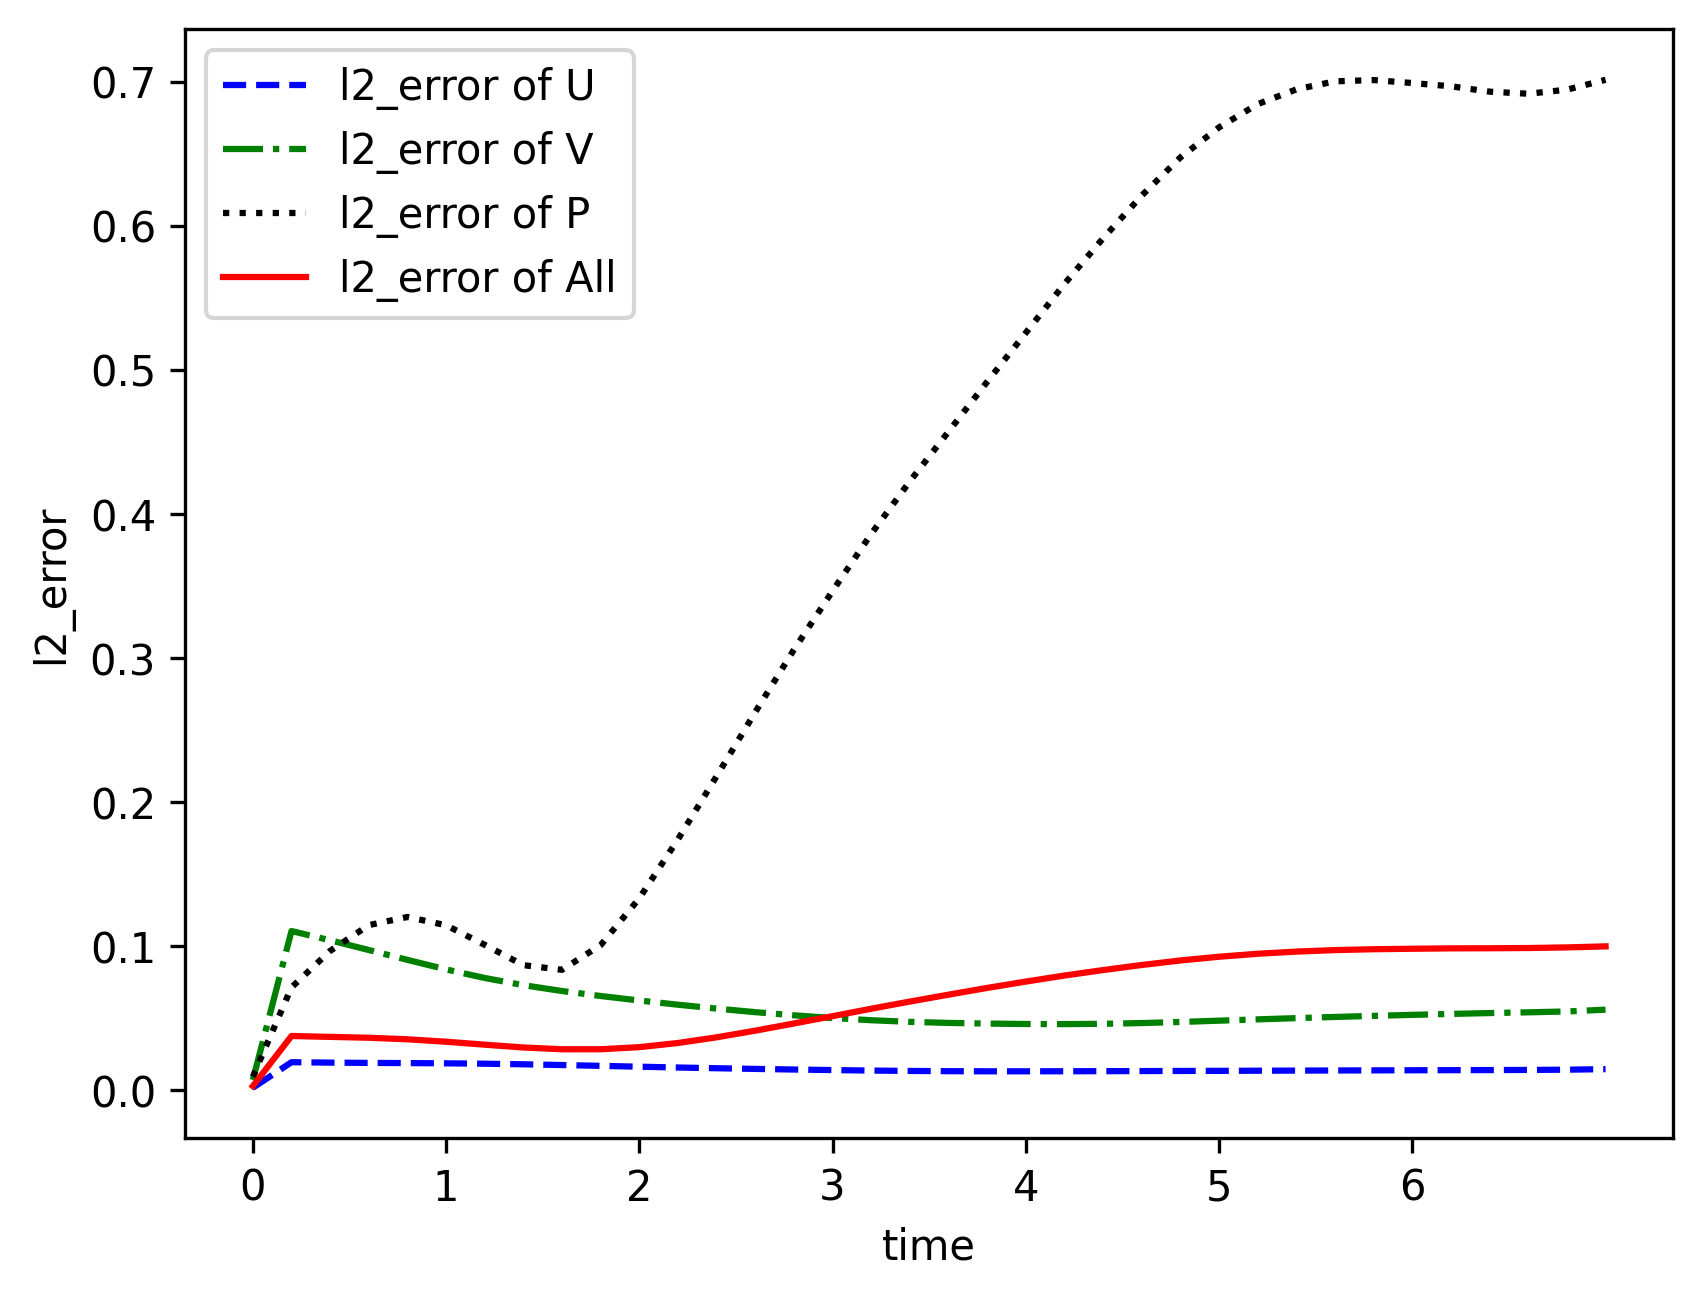

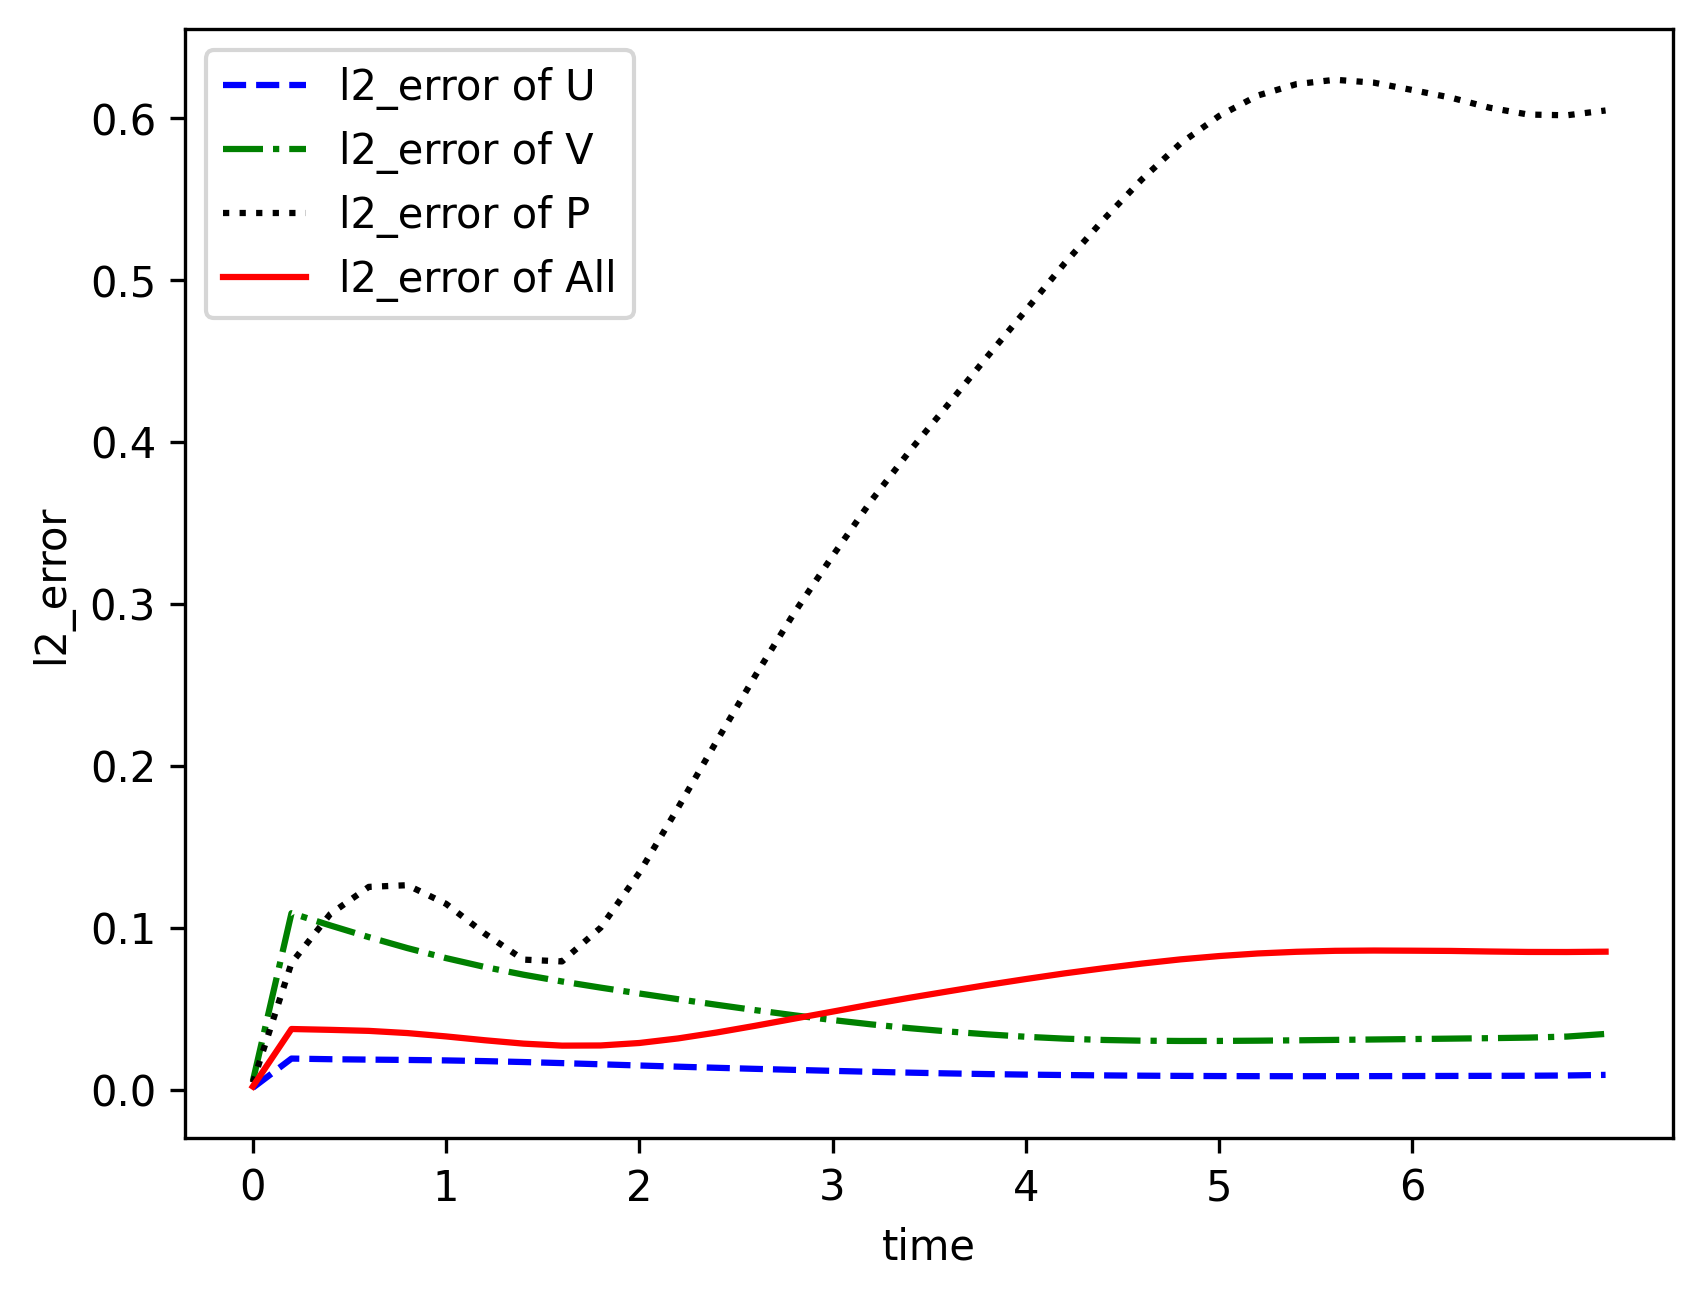

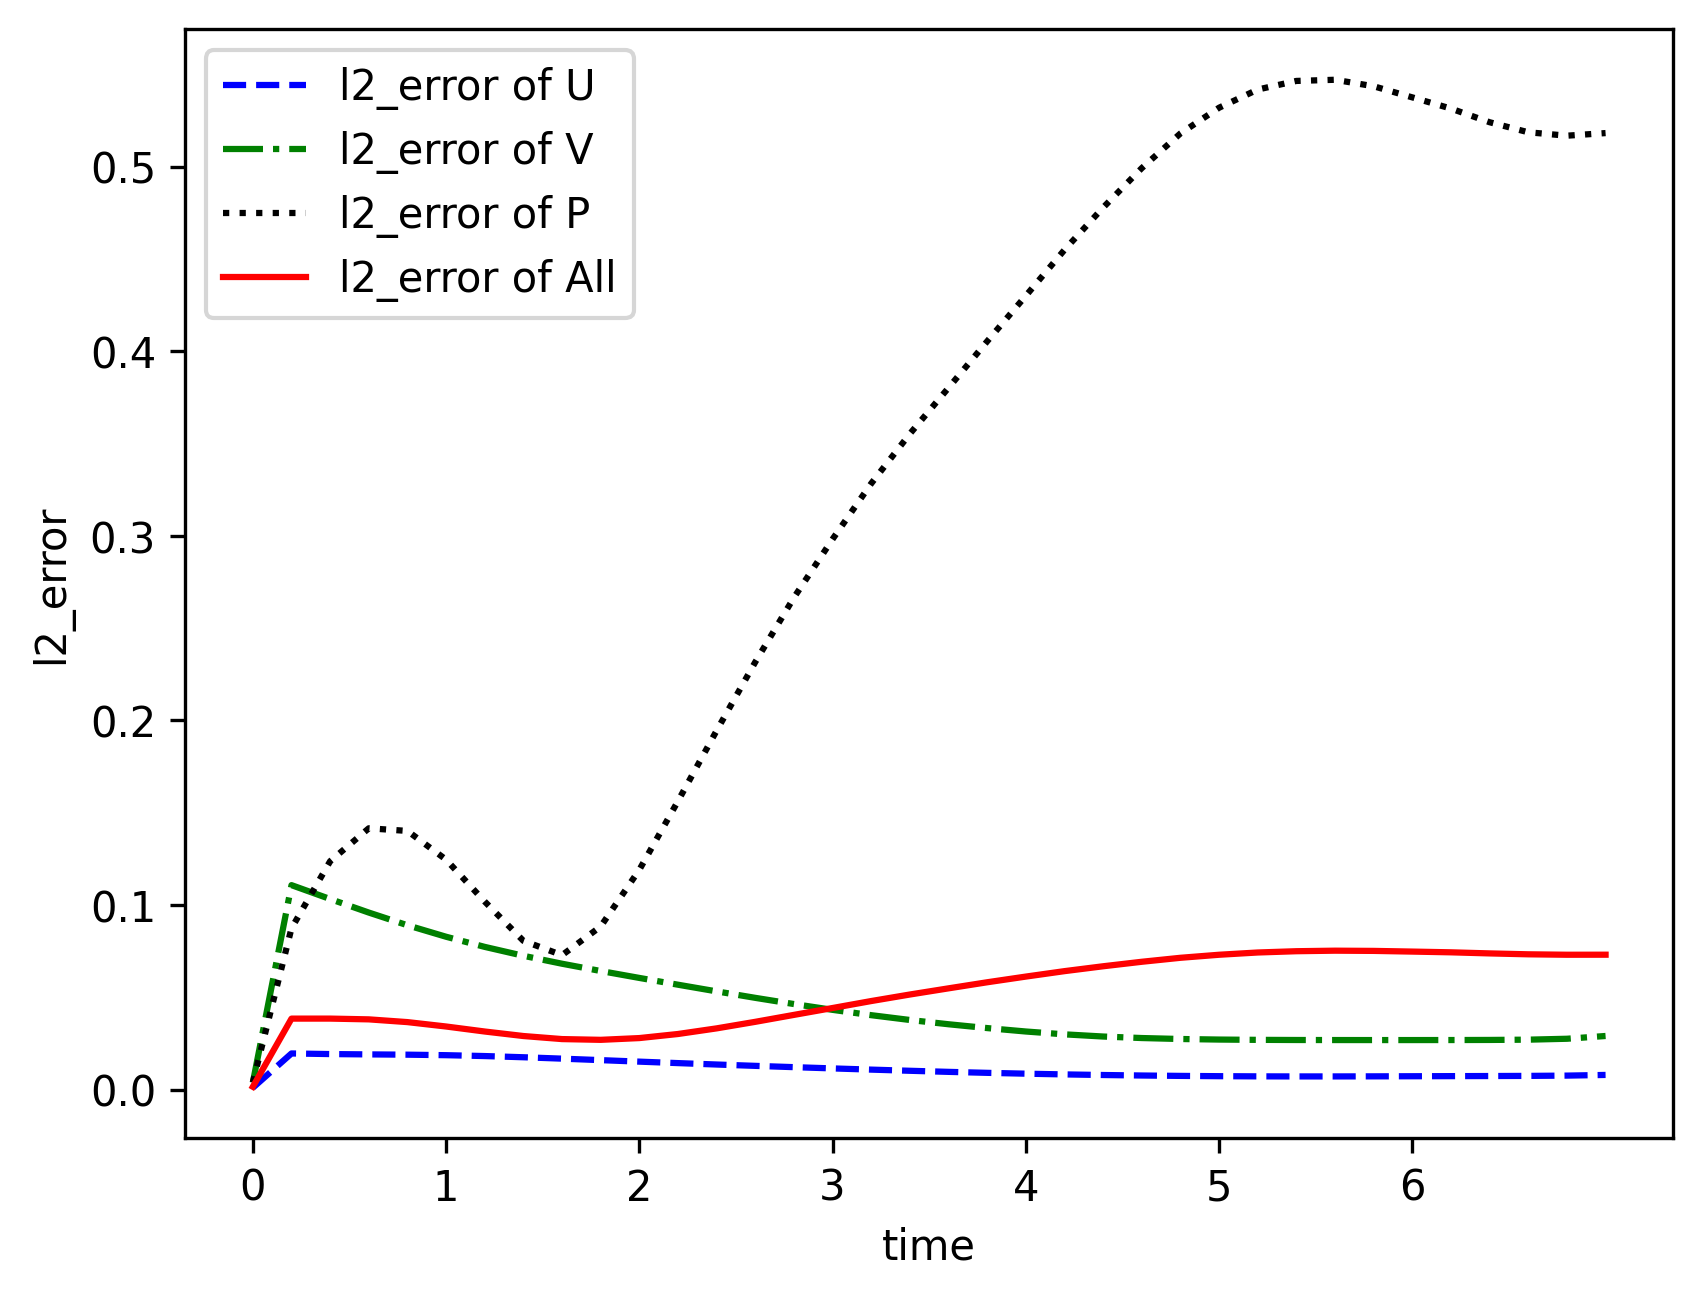

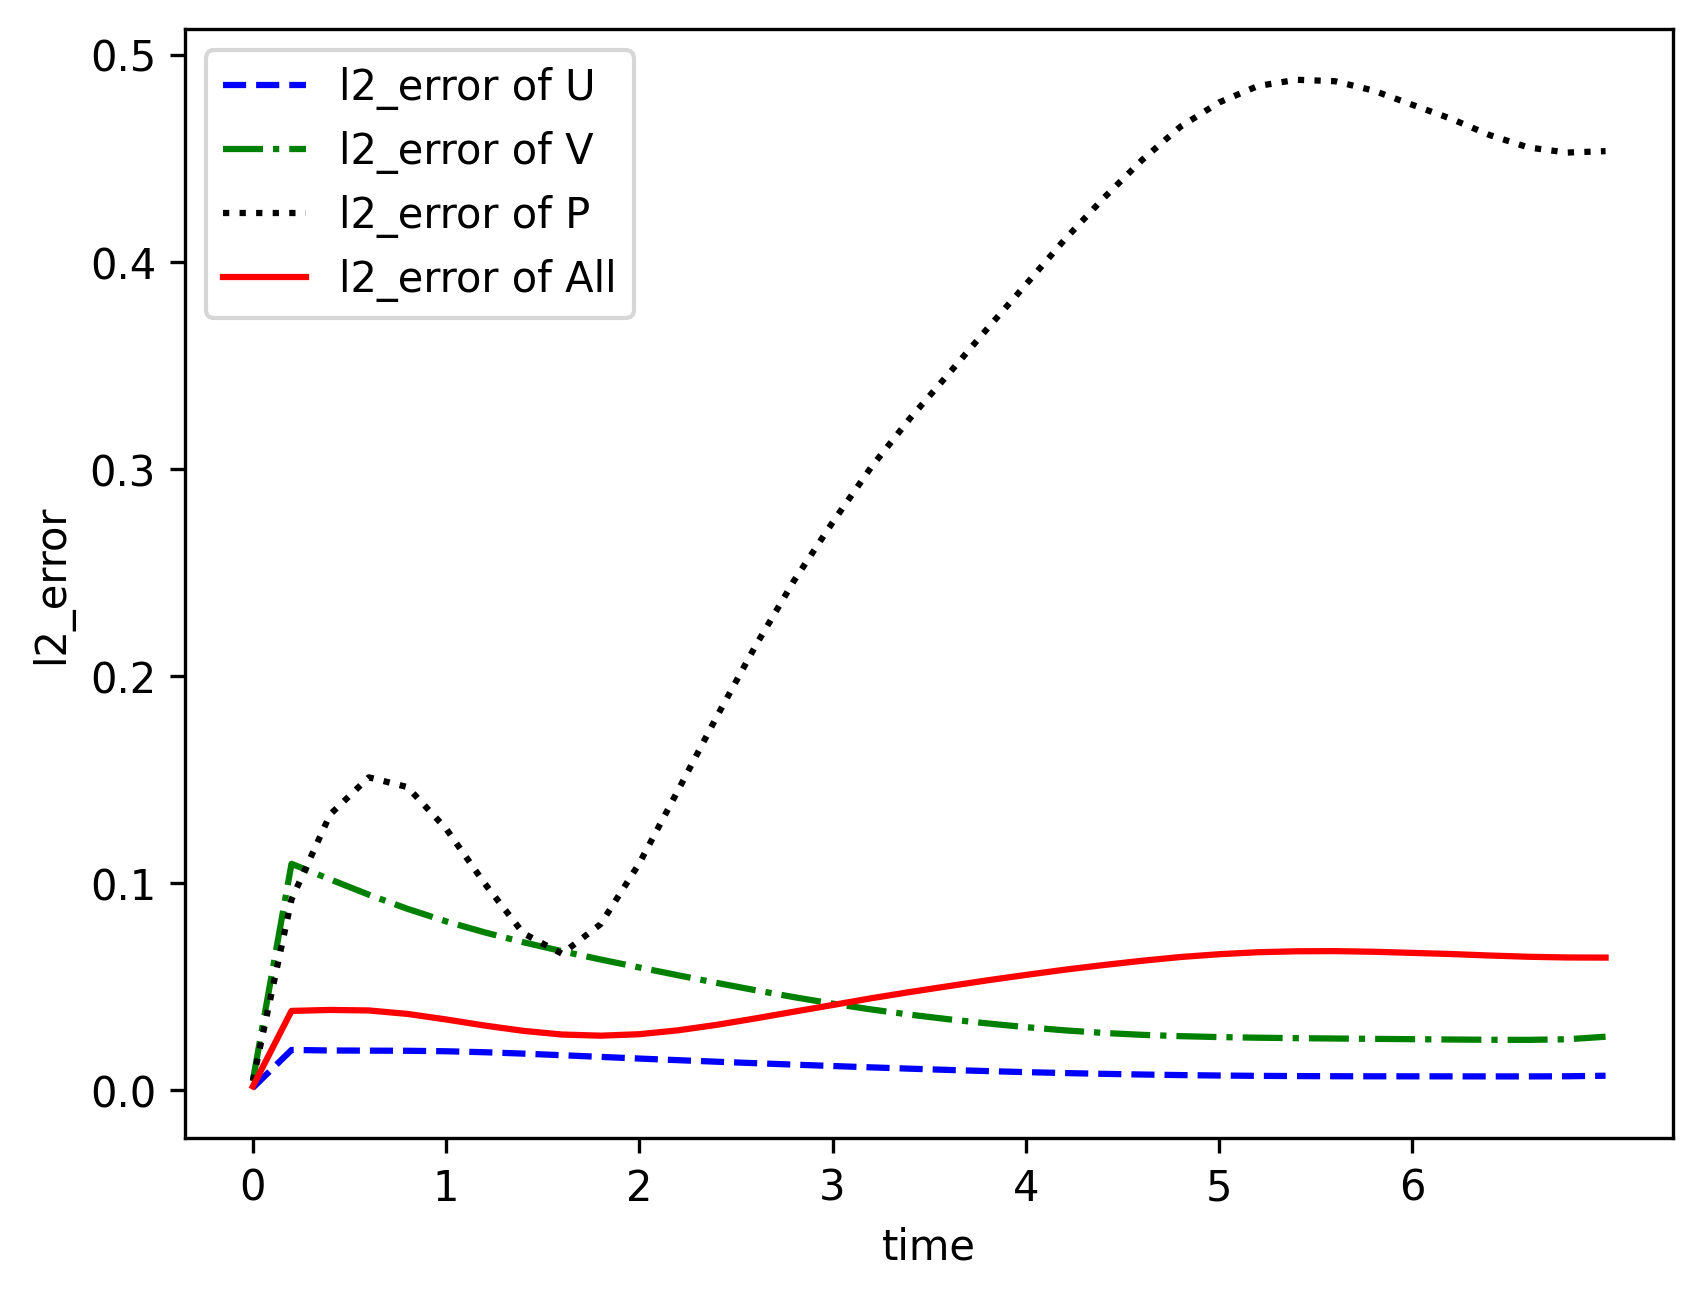

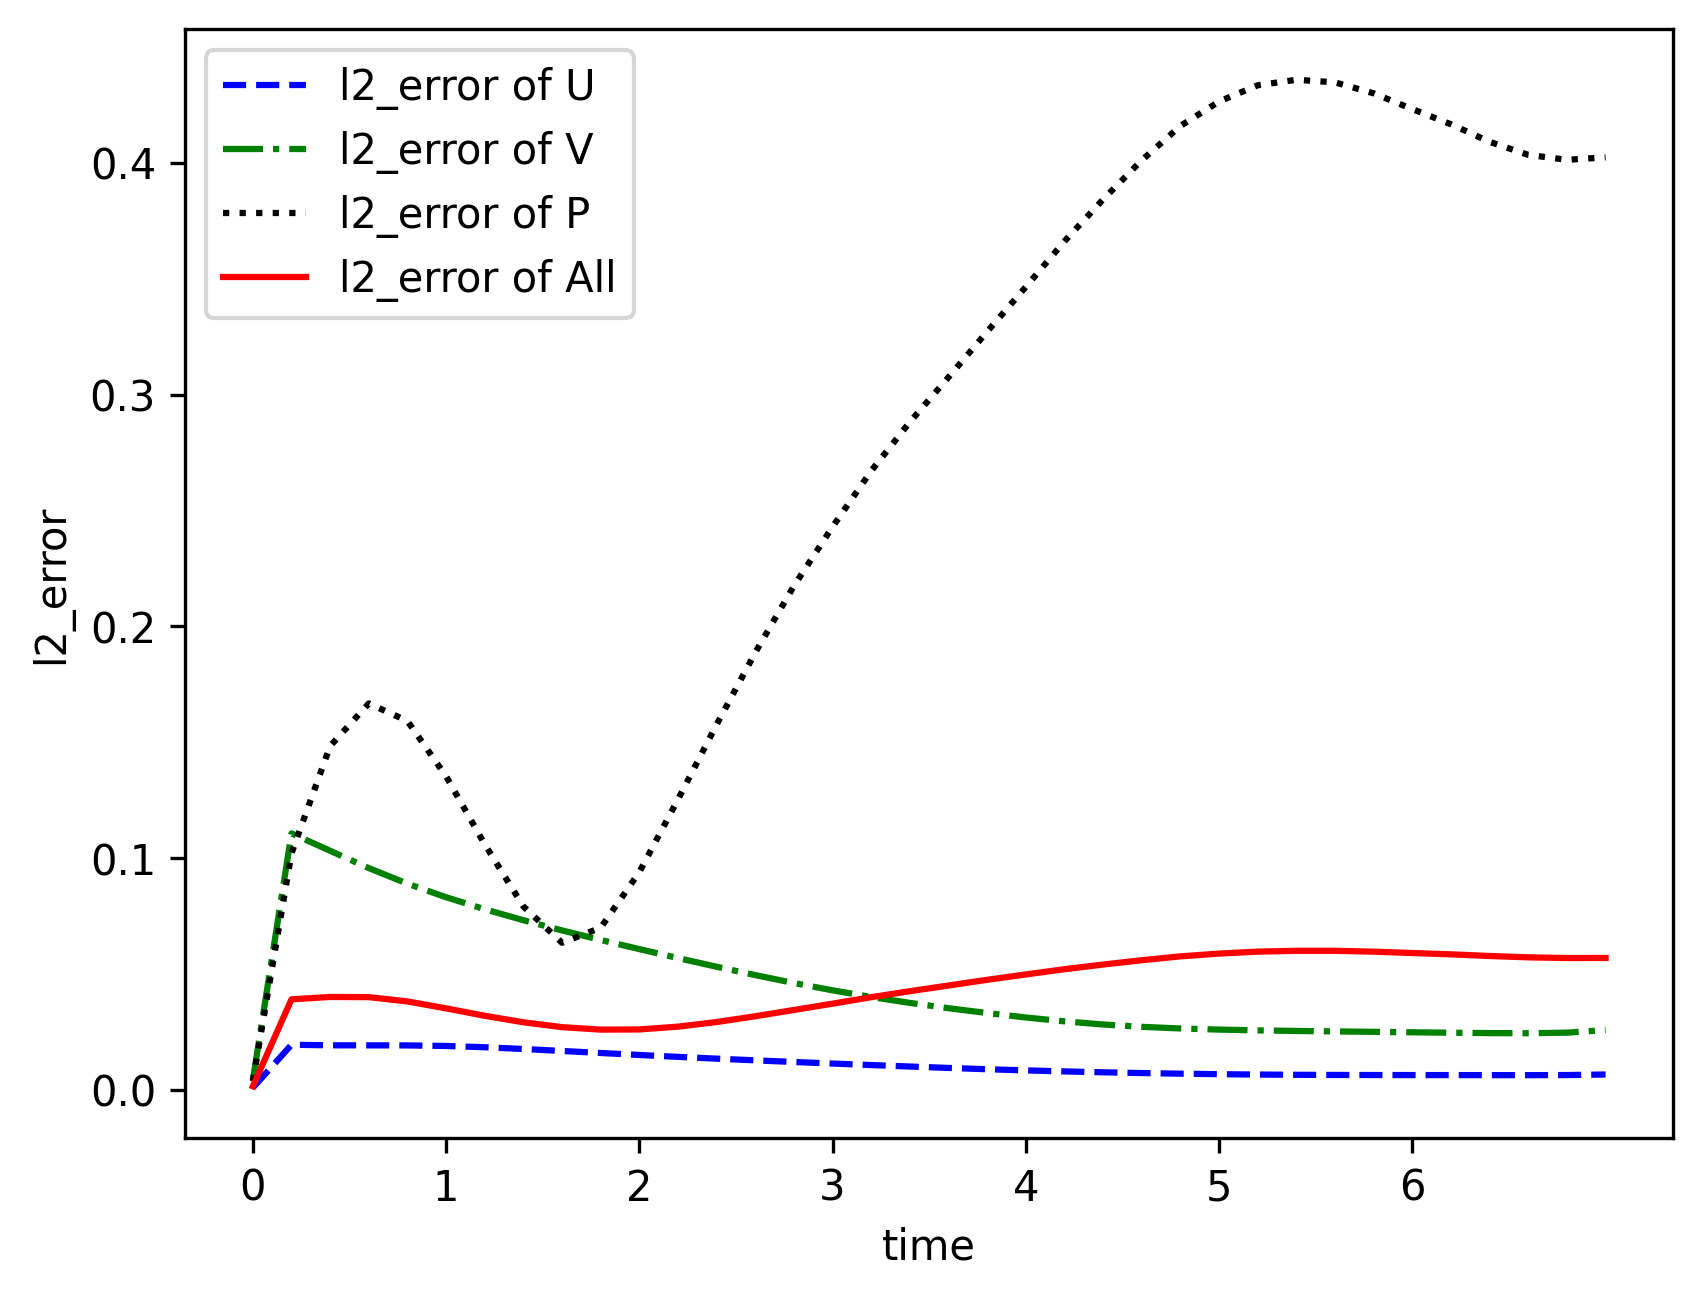

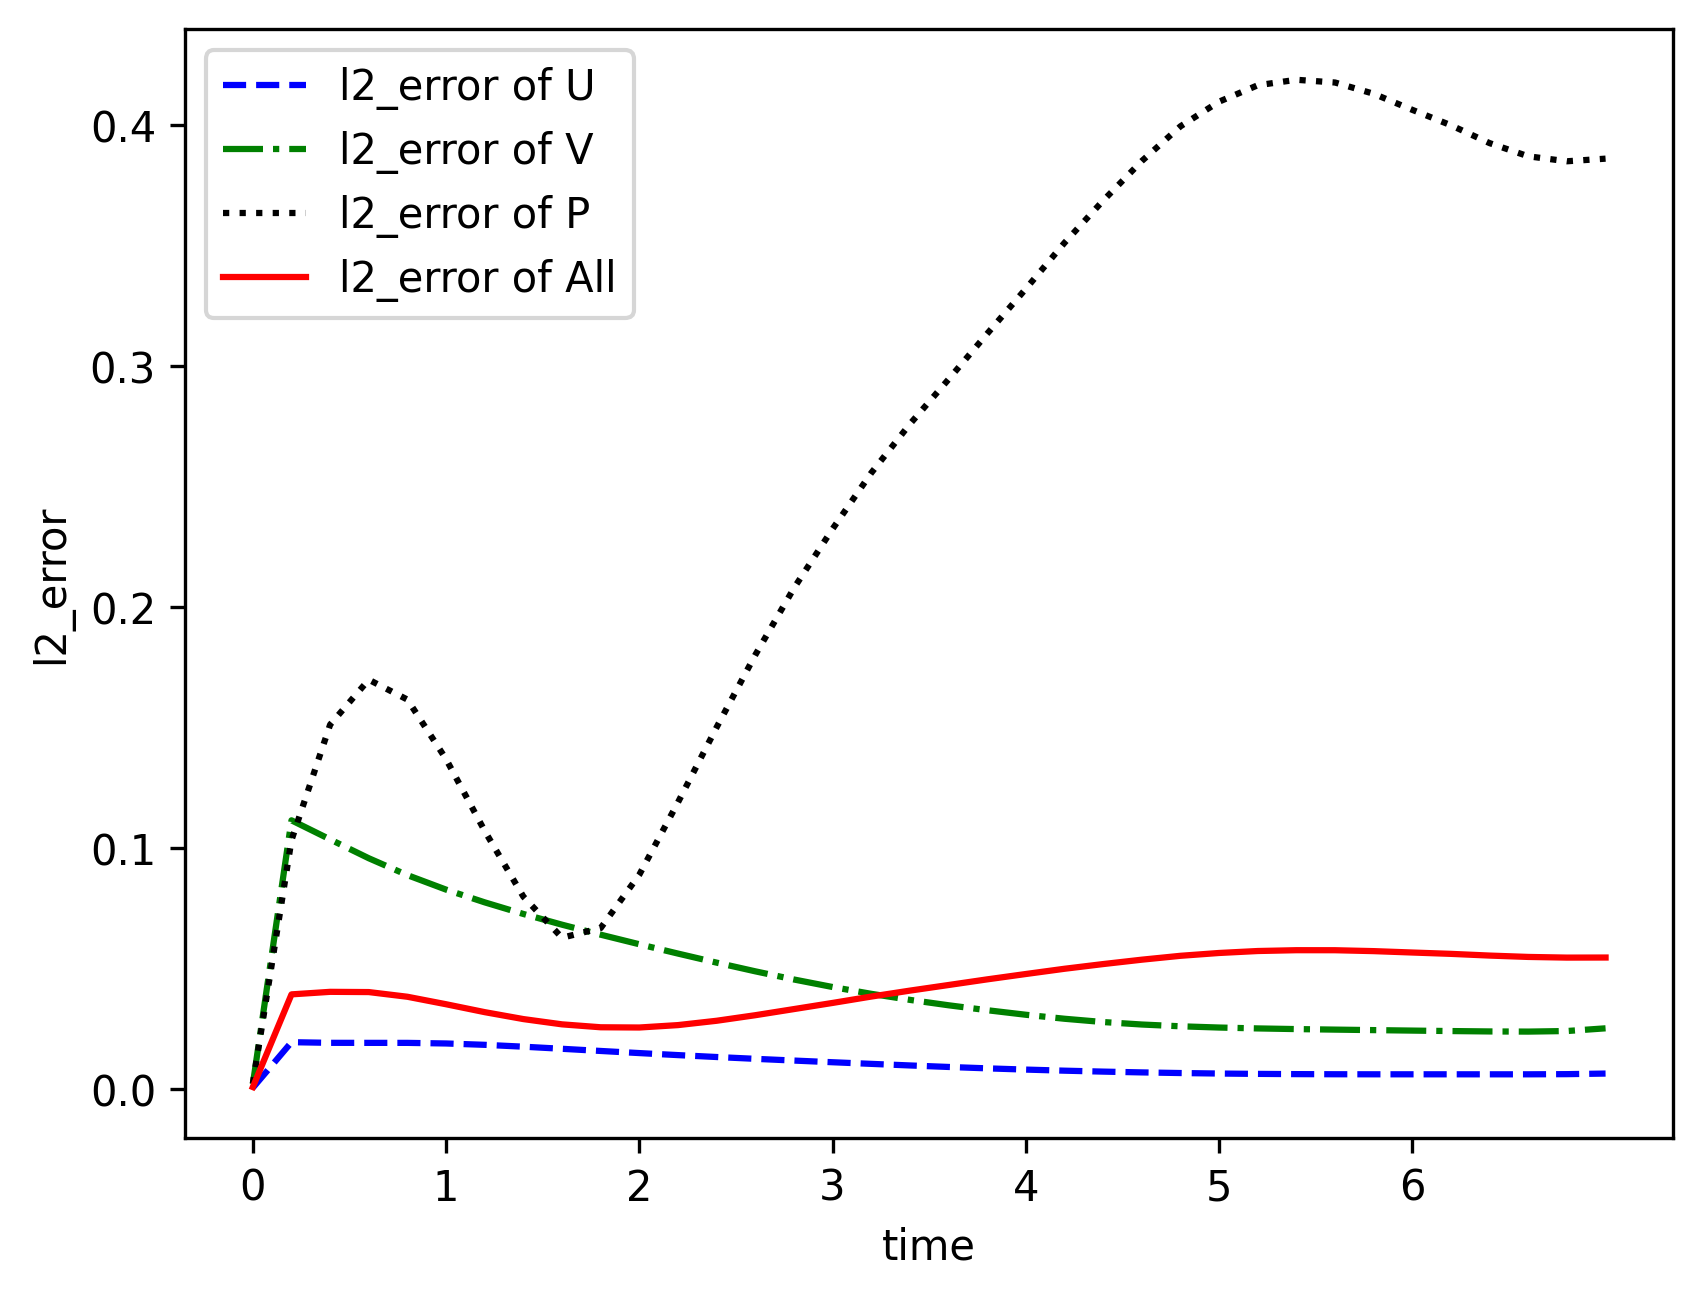

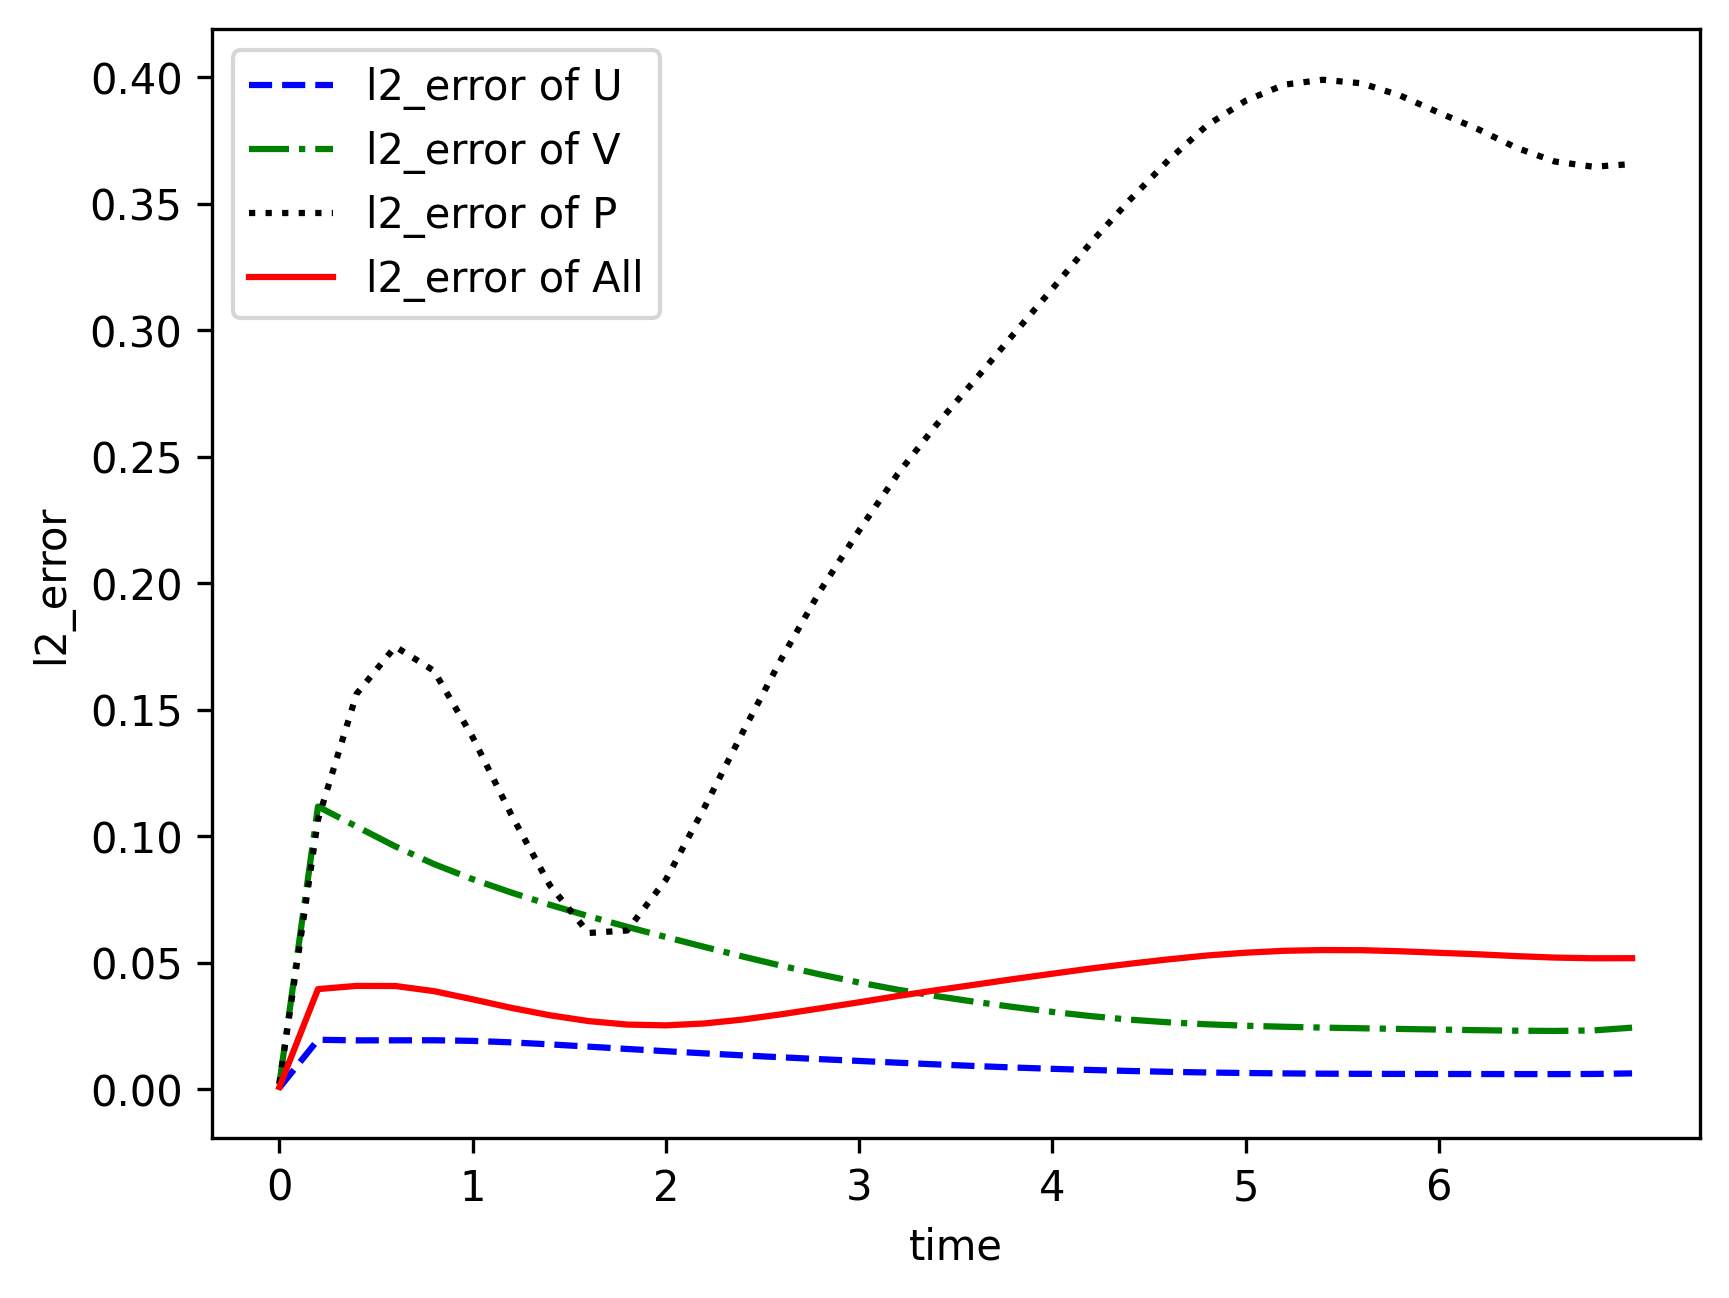

In [11]:
solver.train(config["train_epochs"], train_dataset, callbacks=callbacks, dataset_sink_mode=True)